In [69]:
from glob import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [18]:
for path in glob('competition_data/*.csv'):
    df = pd.read_csv(path)
    print(path, df.shape)

competition_data/comp_threaded.csv (194, 32)
competition_data/comp_adaptor.csv (25, 20)
competition_data/tube_end_form.csv (27, 2)
competition_data/comp_straight.csv (361, 12)
competition_data/comp_tee.csv (4, 14)
competition_data/comp_boss.csv (147, 15)
competition_data/components.csv (2048, 3)
competition_data/comp_float.csv (16, 7)
competition_data/bill_of_materials.csv (21198, 17)
competition_data/comp_elbow.csv (178, 16)
competition_data/type_connection.csv (14, 2)
competition_data/train_set.csv (30213, 8)
competition_data/comp_sleeve.csv (50, 10)
competition_data/test_set.csv (30235, 8)
competition_data/tube.csv (21198, 16)
competition_data/comp_hfl.csv (6, 9)
competition_data/type_end_form.csv (8, 2)
competition_data/comp_other.csv (1001, 3)
competition_data/type_component.csv (29, 2)
competition_data/specs.csv (21198, 11)
competition_data/comp_nut.csv (65, 11)


In [19]:
df.head()

,component_id,component_type_id,hex_nut_size,seat_angle,length,thread_size,thread_pitch,diameter,blind_hole,orientation,weight
0,C-1621,CP-025,20.64,NaN,17.0,.687,16.0,NaN,NaN,No,0.015
1,C-1624,CP-025,34.92,NaN,26.5,1.187,12.0,NaN,NaN,No,0.035
2,C-1623,CP-025,28.58,NaN,23.5,1.000,14.0,NaN,NaN,No,0.044
3,C-1622,CP-025,23.81,NaN,20.0,.812,16.0,NaN,NaN,No,0.036
4,C-1625,CP-025,41.28,NaN,27.5,1.437,12.0,NaN,NaN,No,0.129


In [21]:
import numpy as np
from sklearn.metrics import mean_squared_log_error

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [24]:
trainval = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')

In [25]:
trainval['quote_date'] = pd.to_datetime(trainval['quote_date'], infer_datetime_format=True)
test['quote_date'] = pd.to_datetime(test['quote_date'], infer_datetime_format=True)

In [26]:
trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
test_tube_assemblies = test['tube_assembly_id'].unique()
len(trainval_tube_assemblies), len(test_tube_assemblies)

(8855, 8856)

In [28]:
set(trainval_tube_assemblies) & set(test_tube_assemblies)

set()

In [27]:
trainval_tube_assemblies

array(['TA-00002', 'TA-00004', 'TA-00005', ..., 'TA-21195', 'TA-21196',
       'TA-21197'], dtype=object)

In [29]:
from sklearn.model_selection import train_test_split
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42)

In [30]:
set(train_tube_assemblies) & set(val_tube_assemblies)

set()

In [32]:
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]
train.shape, val.shape, trainval.shape

((22628, 8), (7585, 8), (30213, 8))

In [33]:
target = 'cost'
y_train = train[target]
y_val = val[target]
y_pred = np.full_like(y_val, fill_value=y_train.mean())
print('Validation RMSLE, Mean Baseline:', rmsle(y_val, y_pred))

Validation RMSLE, Mean Baseline: 0.9418101276064408


In [34]:
features = ['quantity']
X_train = train[features]
X_val = val[features]

In [35]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
r2 = model.score(X_val, y_val)
print('Validation R^2', r2)

Validation R^2 0.08879518736792147


In [36]:
y_pred = model.predict(X_val)
print(f'Validation RMSLE, Random Forest with {features}')
print(rmsle(y_val, y_pred))

Validation RMSLE, Random Forest with ['quantity']
0.6908805822519187


In [38]:
def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    X = X.drop(columns='tube_assembly_id')
    
    return X

train_wrangled = wrangle(train)
val_wrangled = wrangle(val)

In [39]:
features = train_wrangled.columns.drop('cost')
print('Features:', features.tolist())

Features: ['supplier', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity', 'quote_date_year', 'quote_date_month']


In [40]:
X_train = train_wrangled[features]
X_val = val_wrangled[features]

In [45]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [48]:
y_val_log = np.log1p(y_val)
rmse(y_val_log, y_pred_log)

0.39501769597010006

In [49]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
rmse(y_val_log, y_pred_log)

0.3950176959701

In [50]:
def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    X = X.drop(columns='tube_assembly_id')
    
    return X

train_wrangled = wrangle(train)
val_wrangled = wrangle(val)

In [51]:
features = train_wrangled.columns.drop('cost')
print('Features:', features.tolist())

Features: ['supplier', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity', 'quote_date_year', 'quote_date_month']


In [52]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
rmse(y_val_log, y_pred_log)

0.3950176959701

In [53]:
y_pred = np.expm1(y_pred_log)
rmsle(y_val, y_pred)

0.3950176959701

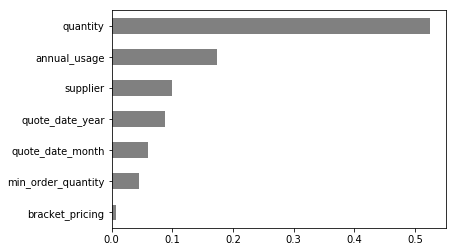

In [55]:
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='grey');

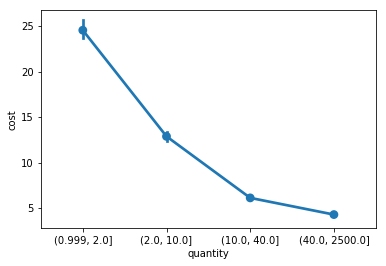

In [59]:
sns.pointplot(x=pd.qcut(train_wrangled['quantity'], q=4), 
              y=train_wrangled['cost']);

In [60]:
for path in glob('competition_data/*.csv'):
    df = pd.read_csv(path)
    shared_columns = set(df.columns) & set(train.columns)
    if shared_columns:
        print(path, df.shape)
        print(df.columns.tolist(), '\n')

competition_data/bill_of_materials.csv (21198, 17)
['tube_assembly_id', 'component_id_1', 'quantity_1', 'component_id_2', 'quantity_2', 'component_id_3', 'quantity_3', 'component_id_4', 'quantity_4', 'component_id_5', 'quantity_5', 'component_id_6', 'quantity_6', 'component_id_7', 'quantity_7', 'component_id_8', 'quantity_8'] 

competition_data/train_set.csv (30213, 8)
['tube_assembly_id', 'supplier', 'quote_date', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity', 'cost'] 

competition_data/test_set.csv (30235, 8)
['id', 'tube_assembly_id', 'supplier', 'quote_date', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity'] 

competition_data/tube.csv (21198, 16)
['tube_assembly_id', 'material_id', 'diameter', 'wall', 'length', 'num_bends', 'bend_radius', 'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'end_a', 'end_x', 'num_boss', 'num_bracket', 'other'] 

competition_data/specs.csv (21198, 11)
['tube_assembly_id', 'spec1', 'spec2', 'spec3', 'spec4', 'spec

In [61]:
tube = pd.read_csv('competition_data/tube.csv')

In [62]:
tube.describe(exclude='number')

,tube_assembly_id,material_id,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x
count,21198,20919,21198,21198,21198,21198,21198,21198
unique,21198,19,2,2,2,2,25,27
top,TA-02652,SP-0029,N,N,N,N,EF-003,EF-003
freq,1,11488,20118,18015,20377,18493,11388,10863


In [103]:
tube = pd.read_csv('competition_data/tube.csv')

for path in glob('competition_data/*.csv'):
    df = pd.read_csv(path)
    shared_columns = set(df.columns) & set(tube.columns)
    if shared_columns:
        print(path, df.shape)
        print(df.columns.tolist(), '\n')

competition_data/bill_of_materials.csv (21198, 17)
['tube_assembly_id', 'component_id_1', 'quantity_1', 'component_id_2', 'quantity_2', 'component_id_3', 'quantity_3', 'component_id_4', 'quantity_4', 'component_id_5', 'quantity_5', 'component_id_6', 'quantity_6', 'component_id_7', 'quantity_7', 'component_id_8', 'quantity_8'] 

competition_data/train_set.csv (30213, 8)
['tube_assembly_id', 'supplier', 'quote_date', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity', 'cost'] 

competition_data/comp_sleeve.csv (50, 10)
['component_id', 'component_type_id', 'connection_type_id', 'length', 'intended_nut_thread', 'intended_nut_pitch', 'unique_feature', 'plating', 'orientation', 'weight'] 

competition_data/test_set.csv (30235, 8)
['id', 'tube_assembly_id', 'supplier', 'quote_date', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity'] 

competition_data/tube.csv (21198, 16)
['tube_assembly_id', 'material_id', 'diameter', 'wall', 'length', 'num_bends', 'bend_r

In [127]:
def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Merge tube data
    tube = pd.read_csv('competition_data/tube.csv')
    bill_of_materials = pd.read_csv('competition_data/bill_of_materials.csv')
    
    X = X.merge(tube, how='left').merge(bill_of_materials, how='left')
    
    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    X = X.drop(columns='tube_assembly_id')
    X.fillna(0, inplace=True)
    
    return X


train_wrangled = wrangle(train)
val_wrangled = wrangle(val)
test_wrangled = wrangle(test)
trainval_wrangled = wrangle(trainval)

In [128]:
target = 'cost'
y_train = train[target]
y_val = val[target]
y_trainval = trainval[target]

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
y_trainval_log = np.log1p(y_trainval)

features = train_wrangled.columns.drop('cost')
X_train = train_wrangled[features]
X_val = val_wrangled[features]
X_trainval = trainval_wrangled[features]

X_test = test_wrangled[features]

In [129]:
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline



pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=1000, random_state=55, n_jobs=-1)
)

pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
rmse(y_val_log, y_pred_log)

0.2991922201502649

In [130]:
test_wrangled = wrangle(test)
X_test = test_wrangled.drop(columns='id')
all(X_test.columns == X_train.columns)

True

In [117]:
# kill truncation  
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [131]:
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission['cost'] = y_pred
submission.to_csv('dwight-submission-01.csv', index=False)